In [4]:
from bspline   import elements_spans  # computes the span for each element
from bspline   import make_knots,basis_funs,find_span     # create a knot sequence from a grid
from bspline   import quadrature_grid ,breakpoints# create a quadrature rule over the whole 1d grid
from bspline   import basis_ders_on_quad_grid,basis_funs_all_ders # evaluates all bsplines and their derivatives on the quad grid
from Gauss_Legendre import Gauss_Legendre, quadrature_grid

from stdio     import Mass_Matrix, Stiffness_Matrix, assemble_rhs_with_Non_homogenuous_DBC
from stdio     import B_Spline_Least_Square, assemble_stiffness_2D, L2_projection,L2_projectionVec
from equipment import L2_norm_2D, H1_norm_2D, plot_field_2D
from scipy.sparse.linalg import cg
from scipy.linalg import norm, inv, solve, det,inv
from numpy import zeros, ones, linspace,double,float64, cos,array, dot, zeros_like, asarray,floor,arange,append,random,sqrt, int32, meshgrid, kron,sin
import  matplotlib.pyplot as plt
from scipy.sparse        import csr_matrix
from scipy.sparse        import csc_matrix, linalg as sla
from scipy.sparse.linalg import gmres
from numpy               import zeros, linalg, asarray
from numpy               import cos, pi

#from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from pyccel.decorators import types
from  pykronecker import KroneckerProduct


/home/abdessadek/.local/lib/python3.8/site-packages/pyccel/decorators.py:61: FutureWarning: The @types decorator will be removed in a future version of Pyccel. Please use type hints. The @template decorator can be used to specify multiple types. See the documentation at https://github.com/pyccel/pyccel/blob/devel/docs/quickstart.md#type-annotationsfor examples.
  warnings.warn("The @types decorator will be removed in a future version of " +


Using NumPy backend


In [5]:
ne1, ne2                = (32, 32)
grid1, grid2            = linspace(0,1,ne1+1), linspace(0,1, ne2+1)            
p1,p2                   = (2,2)
knots1, knots2          = make_knots(grid1, p1, False), make_knots(grid2, p2, False)
spans1, spans2          = elements_spans(knots1, p1), elements_spans(knots2, p2)
nelements1, nelements2  = len(grid1)-1,len(grid2)-1
nbasis1, nbasis2        = len(knots1)-p1-1, len(knots2)-p2-1
nders                   = 1
U1 , W1                 = Gauss_Legendre(p1)
U2 , W2                 = Gauss_Legendre(p2)
points1, weights1       = quadrature_grid(grid1,U1,W1)
points2, weights2       = quadrature_grid(grid2,U2,W2)
basis1, basis2          = basis_ders_on_quad_grid(knots1, p1, points1, nders, normalize=False),basis_ders_on_quad_grid(knots2, p2, points2, nders, normalize=False)

In [6]:
@types('double[:,:,:,:]', 'int', 'int')
def tensor_to_matrix(Mat, nh, nm):
    sti = zeros((nh * nm, nh * nm), dtype=double)
    for i in range(nh):
        for j in range(nm):
            for k in range(nh):
                for l in range(nm):
                    i_1 = k + i * nm
                    i_2 = l + j * nh
                    sti[i_1, i_2] = Mat[i, j, k, l]                    
    return sti   

/home/abdessadek/.local/lib/python3.8/site-packages/pyccel/decorators.py:61: FutureWarning: The @types decorator will be removed in a future version of Pyccel. Please use type hints. The @template decorator can be used to specify multiple types. See the documentation at https://github.com/pyccel/pyccel/blob/devel/docs/quickstart.md#type-annotationsfor examples.
  warnings.warn("The @types decorator will be removed in a future version of " +


In [7]:
'''
in 2D isogeometric analysis, the Kronecker assembly process involves
constructing the global stiffness or mass matrix by combining element-level
matrices using Kronecker products.This method leverages the tensor-product structure 
of the basis functions in IGA to efficiently assemble the global matrices
'''

stiffness1      = zeros((nbasis1,nbasis1))
stiffness2      = zeros((nbasis2,nbasis2))
mass1           = zeros((nbasis1,nbasis1))
mass2           = zeros((nbasis2,nbasis2))
stiffness1      = Stiffness_Matrix(nelements1, p1, spans1, basis1, weights1, points1, stiffness1)
stiffness2      = Stiffness_Matrix(nelements2, p2, spans2, basis2, weights2, points2, stiffness2)
mass1           = Mass_Matrix(nelements1, p1, spans1, basis1, weights1, points1, mass1)
mass2           = Mass_Matrix(nelements2, p2, spans2, basis2, weights2, points2, mass2)
C1              = kron(stiffness1[1:-1,1:-1],mass2[1:-1,1:-1])

C2              = kron(mass1[1:-1,1:-1], stiffness2[1:-1,1:-1])
# C1              = kron(stiffness1,mass2)
# C2              = kron(mass1,stiffness2)
stiffness = C1+C2

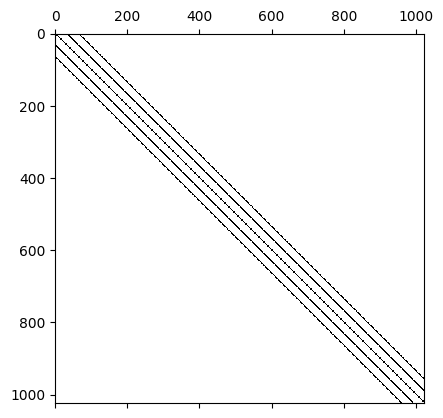

In [8]:
plt.spy(stiffness)
plt.show()

In [9]:

stiffness = zeros((nbasis1, nbasis2, nbasis1, nbasis2))
stiffness = assemble_stiffness_2D(nelements1, nelements2, p1, p2, spans1, spans2, basis1, basis2, weights1, weights2, points1, points2, stiffness)
stiffness = tensor_to_matrix(stiffness[1:-1,1:-1,1:-1,1:-1], nbasis1-2, nbasis2-2)


## Boundary  Dirichlet conditions on unit square.

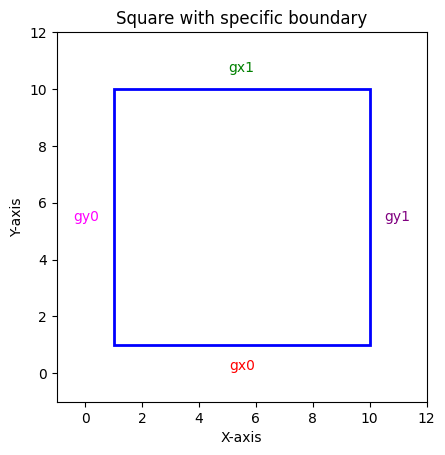

In [10]:
# Define the boundaries of the square
left     = 1
right    = 10
top      = 10
bottom   = 1
square   = plt.Rectangle((left, bottom), right - left, top - bottom, edgecolor='blue', facecolor='none',  linewidth=2)
fig, ax  = plt.subplots()
ax.add_patch(square)
ax.set_xlim(left -2, right + 2)
ax.set_ylim(bottom -2, top + 2)
ax.set_aspect('equal')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.text(left + (right - left) / 2, bottom - 0.5, 'gx0', ha='center', va='top', fontsize=10, color='red')
ax.text(left + (right - left) / 2, top + 0.5, 'gx1', ha='center', va='bottom', fontsize=10, color='green')
ax.text(left - 0.5, bottom + (top - bottom) / 2, 'gy0', ha='right', va='center', fontsize=10, color='magenta')
ax.text(right + 0.5, bottom + (top - bottom) / 2, 'gy1', ha='left', va='center', fontsize=10, color='purple')
plt.title("Square with specific boundary")
plt.show()

In [12]:
#Test 1

# gx0 = lambda x    :  0.
# gx1 = lambda x    :  0.
# gy0 = lambda y    :  0. 
# gy1 = lambda y    : 0.
# Uex = lambda x, y : 1.-x**2-y**2
# dUx = lambda x, y : -2*x 
# dUy = lambda x, y : -2*y
# f   = lambda x, y : 0.*x+4.

# Test 2
F1= lambda x1, x2 : (2.0*x1-1.0)*sqrt(1.0-0.5*(2.0*x2-1.0)**2)
F2= lambda x1, x2 : (2.0*x2-1.0)*sqrt(1.0-0.5*(2.0*x1-1.0)**2)


# Xc        = (2.0*0-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)
# Xc        = (2.0*1-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)

Uex = lambda x, y:  sin(pi*x)*sin(pi*y)
dUx = lambda x, y : pi*cos(pi*x)*sin(pi*y)
dUy = lambda x, y : pi*sin(pi*x)*cos(pi*y)
f   = lambda x, y : 2*pi**2*sin(pi*x)*sin(pi*y)
# Yc        = (2.0*0-1.)*sqrt(1.0-0.5*(2.0*X-1.0)**2)
# Yc        = (2.0*1-1.)*sqrt(1.0-0.5*(2.0*X-1.0)**2)
'''
gx0 = lambda x    :  0.
gx1 = lambda x    :  2.* cos(pi*x)
gy0 = lambda y    :  2.* y 
gy1 = lambda y    : -2.* y
Uex = lambda x, y : 2.*x*cos(pi*y) 
dUx = lambda x, y : 2.*cos(pi*y)  
dUy = lambda x, y : -2*pi*x*sin(pi*y)
f   = lambda x, y : 2.*x*pi**2*cos(pi*y)
'''
# kappa = 1
# gx0   = lambda x   :  1 - sin(2*kappa*pi*x) 
# gx1   = lambda x   : -1- sin(2*kappa*pi*x)
# gy0   = lambda y   : cos(pi*kappa*y)
# gy1   = lambda y   : cos(pi*kappa*y)
# Uex   = lambda x,y : cos(pi*kappa*x)- sin(2*kappa*pi*y)
# dUx   = lambda x,y : -pi*kappa*sin(pi*kappa*x)
# dUy   = lambda x,y : - 2*kappa*pi*cos(2*kappa*pi*y)
# f     = lambda x,y : (pi*kappa)**2*cos(pi*kappa*x)- (2*kappa*pi)**2*sin(2*kappa*pi*y)

rhs1          = zeros((nbasis1,nbasis2))
###################################################B-spline least square ####################################
# gx0_h         = B_Spline_Least_Square(nelements1, gx0, p1, spans1, basis1, weights1, points1)
# gx1_h         = B_Spline_Least_Square(nelements1, gx1, p1, spans1, basis1, weights1, points1)
# gy0_h         = B_Spline_Least_Square(nelements2, gy0, p2, spans2, basis2, weights2, points2)
# gy1_h         = B_Spline_Least_Square(nelements2, gy1, p2, spans2, basis2, weights2, points2)
################################################### L2 projection ############################################
@types('double[:]', 'int', 'double','double', 'double', 'double' 'double')
def L2_projection(knots, p, g, alpha):
    nbasis = len(knots) - p - 1
    X      = linspace(knots[0], knots[-p], nbasis)
    matrix      = zeros((nbasis, nbasis))
    G      = zeros(nbasis)
    for i ,ix in enumerate(X):
        i_span    = find_span(knots, p, ix)
        values_xi = basis_funs(knots, p, ix,  i_span)
        matrix[i,i_span- p: i_span+1 ] = values_xi[:]
        x   = (2.0*alpha-1.0)*sqrt(1.0-0.5*(2.0*ix-1.0)**2)
        # x             = (2.0*x1-1.0)*sqrt(1.0-0.5*(2.0*x2-1.0)**2)
        # y             = (2.0*x2-1.0)*sqrt(1.0-0.5*(2.0*x1-1.0)**2)     
        G[i] = g(ix)
    lu    = sla.splu(csc_matrix(matrix))
    gh    = lu.solve(G) 
    return gh
# def L2_projection_y(knots, p, g, alpha):
#     nbasis = len(knots) - p - 1
#     X      = linspace(knots[0], knots[-p], nbasis)
#     matrix      = zeros((nbasis, nbasis))
#     G      = zeros(nbasis)
#     for i ,ix in enumerate(X):
#         i_span    = find_span(knots, p, ix)
#         values_xi = basis_funs(knots, p,  ix, i_span)
#         matrix[i,i_span- p: i_span+1 ] = values_xi[:]
#         x   = (2.0*ix-1.0)*sqrt(1.0-0.5*(2.0*alpha-1.0)**2)
#         G[i] = g(x)
    
#     lu    = sla.splu(csc_matrix(matrix))
#     gh    = lu.solve(G) 
#     return gh
X      = linspace(knots1[0], knots1[-p1], nbasis1)
gx0    = Uex(F1(0,X),F2(0,X))
gx0_h         = L2_projectionVec(knots2, p2, X, gx0)
gx1    = Uex(F1(1,X),F2(1,X))
gx1_h         = L2_projectionVec(knots2, p2, X, gx1)
gy0    = Uex(F1(X,0),F2(X,0))
gy0_h         = L2_projectionVec(knots1, p1, X, gy0)
gy1    = Uex(F1(X,1),F2(X,1))
gy1_h         = L2_projectionVec(knots1, p1, X, gy1)

g_bou         = zeros((nbasis1, nbasis2), dtype = double)
g_bou[0,:]    = gx0_h
g_bou[-1,:]   = gx1_h
g_bou[:,0]    = gy0_h
g_bou[:,-1]   = gy1_h
rhs1          = assemble_rhs_with_Non_homogenuous_DBC(f, g_bou, nelements1, nelements2, p1, p2, spans1, spans2, basis1, basis2, weights1, weights2, points1, points2, rhs1)
rhs1          = rhs1[1:-1, 1:-1]
rhs1          = rhs1.reshape((nbasis1-2)*(nbasis2-2))

In [13]:
lu            = sla.splu(csc_matrix(stiffness))
Uapp          = lu.solve(rhs1) 
Uh            = zeros((nbasis1,nbasis2))
Uh[1:-1,1:-1] = Uapp.reshape((nbasis1-2),(nbasis2-2))
Uh            = Uh + g_bou

In [14]:
@types('double[:]', 'double[:]', 'int', 'int', 'double[:]', 'int', 'int')
def plot_field_2D(knots1, knots2, degree1, degree2, u, nx = 101, ny=101):
    xmin, xmax, ymin ,ymax = knots1[degree1], knots1[-degree1], knots2[degree2], knots2[-degree2]
    
    xs = linspace(xmin, xmax, nx)
    ys = linspace(ymin, ymax, ny)
    
    P = zeros((nx,ny,1))
    nu1,nu2 = u.shape
    Q = zeros((nu1,nu2))
    Q[:,:]= u[:,:]
    for i ,xi in enumerate(xs):
        for j,yj in enumerate(xs):
            i_span = find_span(knots1, degree1, xi)
            j_span = find_span(knots2, degree2, yj)
            valuesx = basis_funs(knots1, degree1, xi, i_span)
            valuesy = basis_funs(knots2, degree2, yj, j_span)
            C = zeros(P.shape[-1])
            for i_1 in range(degree1+1):
                for j_1 in range(degree2+1):
                    C[:]+=valuesx[i_1]*valuesy[j_1]*Q[i_span-degree1+i_1, j_span-degree2+j_1]
            P[i,j,:] = C[:]
    X,Y = meshgrid(xs,ys)
    ax = plt.axes(projection = '3d')
    Xc        = (2.0*X-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)
    Yc        = (2.0*Y-1.)*sqrt(1.0-0.5*(2.0*X-1.0)**2)
    # Xc        = (2.0*X-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)
    # Yc        = 
    # plt.contourf(Xc, Yc, P[:,:,0].T, cmap='Greens')
    # plt.colorbar()
    
    
    ax.plot_surface(Xc,Yc, P[:,:,0].T,cmap='viridis',linewidth=0, antialiased=False)
    # ax.plot_surface(X,Y, P[:,:,0].T, cmap ='viridis', edgecolor ='orange')

    # ax.plot_surface(Xc, Yc, P[:,:,0].T, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # ax.set_title('Approximate solution')
    ax.set_xlabel('Xc',  fontweight ='bold')
    ax.set_ylabel('Yc',  fontweight ='bold')
    plt.savefig('Poisson3D_Appro.png')
    # Add a color bar which maps values to colors.
    plt.show()

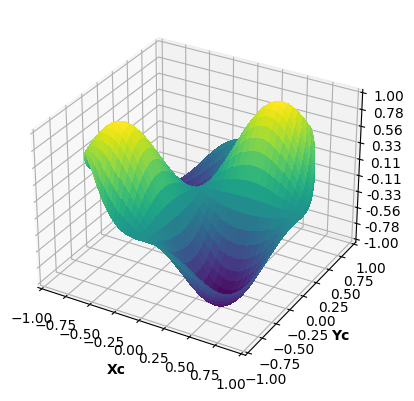

In [15]:
plot_field_2D(knots1,knots2, p1, p2, Uh)

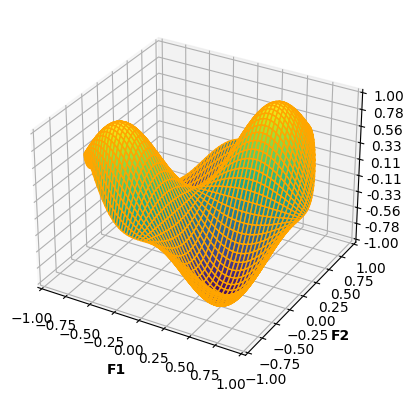

In [16]:
nbpts = 250
xs = ys = linspace(0., 1., nbpts)
teta = linspace(0, 1, nbpts)
r = linspace(0, 1, nbpts)
X, Y = meshgrid(r, teta)#meshgrid(xs, ys)
Xc        = (2.0*X-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)
Yc        =  (2.0*Y-1.)*sqrt(1.0-0.5*(2.0*X-1.0)**2)


sol = zeros((nbpts, nbpts))
for i in range(nbpts) :
    for j in range(nbpts) :
        sol[i, j] = Uex(Xc[i,j], Yc[i,j])
# sol =  Uex(Xc, Yc)
ax = plt.axes(projection = '3d')
    
ax.plot_surface(Xc,Yc, sol, cmap ='viridis', edgecolor ='orange')
# ax.plot_surface(Xc, Yc, sol, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# ax.plot_surface(Xc, Yc, sol, cmap='viridis',linewidth=0, antialiased=False)
# plt.contourf(Xc, Yc, sol, cmap='Greens')
# plt.colorbar()
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('F1',  fontweight ='bold')
ax.set_ylabel('F2',  fontweight ='bold')
plt.savefig('Poisson3D.png')
# plt.contourf(X,Y, sol)


In [17]:
L2 = L2_norm_2D( nelements1, nelements2, p1, p2, spans1, spans2, basis1, basis2, weights1, weights2, points1, points2, Uh, Uex)
L2


5.0935655466206546e-05

In [ ]:

H1 = H1_norm_2D( nelements1, nelements2, p1, p2, spans1, spans2, basis1, basis2, weights1, weights2, points1, points2, Uh, dUx, dUy, Uex)
H1

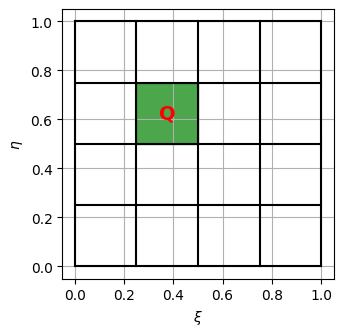

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 3.5))
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Plot the grid
plt.plot(X, Y, color='black')
plt.plot(Y, X, color='black')

# Define the coordinates for the middle sub-square
middle_square_x = [0.25, 0.5, 0.5, 0.25]
middle_square_y = [0.5, 0.5, 0.75, 0.75]

# Color the middle sub-square
plt.fill(middle_square_x, middle_square_y, color='green', alpha=0.7)

# Add a label to the middle sub-square
plt.text((0.5+0.25)/2, (0.5+0.75)/2, 'Q', ha='center', va='center', fontsize=14, color='red', fontweight='bold')
# plt.title('The mesh in Parametric Domain')
plt.grid()
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\eta$')
plt.savefig('The mesh in Parametric Domain.png',bbox_inches='tight', dpi=300)
plt.show()


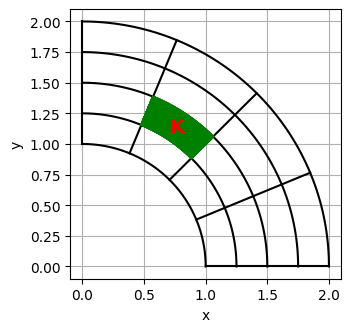

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 3.5))

# Define radii
r1 = 1
r2 = 2
rin1 = 1.25
rin2 = 1.50
rin3 = 1.75

# Define angles
theta = np.linspace(0, np.pi/2, 100)

# Plot the circular arcs
plt.plot(r1 * np.cos(theta), r1 * np.sin(theta), color='black')
plt.plot(r2 * np.cos(theta), r2 * np.sin(theta), color='black')
plt.plot(rin1 * np.cos(theta), rin1 * np.sin(theta), color='black')
plt.plot(rin2 * np.cos(theta), rin2 * np.sin(theta), color='black')
plt.plot(rin3 * np.cos(theta), rin3 * np.sin(theta), color='black')

# Plot the radial lines
t = np.linspace(0, 1, 100)
plt.plot(t * r2 + (1 - t) * r1, np.zeros(len(t)), color='black')
plt.plot(np.zeros(len(t)), t * r2 + (1 - t) * r1, color='black')
theta1 = np.pi / 4
plt.plot(t * r2 * np.cos(theta1) + (1 - t) * r1 * np.cos(theta1), t * r2 * np.sin(theta1) + (1 - t) * r1 * np.sin(theta1), color='black')
theta2 = np.pi / 8
plt.plot(t * r2 * np.cos(theta2) + (1 - t) * r1 * np.cos(theta2), t * r2 * np.sin(theta2) + (1 - t) * r1 * np.sin(theta2), color='black')
theta3 = 3 * np.pi / 8
plt.plot(t * r2 * np.cos(theta3) + (1 - t) * r1 * np.cos(theta3), t * r2 * np.sin(theta3) + (1 - t) * r1 * np.sin(theta3), color='black')
#Define the corresponding sub
r_midlle = (rin1+rin2)/2

X_midlle = r_midlle*np.cos(5*np.pi/16)
Y_midlle = r_midlle*np.sin(5*np.pi/16)
t= np.linspace(theta1, theta3,300)
for ri in np.linspace(rin1 , rin2, 300):
    Xc1 = ri*np.cos(t)
    Yc1 = ri*np.sin(t)
    plt.plot(Xc1, Yc1, color = 'green')
 
plt.text(X_midlle, Y_midlle, 'K', ha='center', va='center', fontsize=14, color='red', fontweight='bold')

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
# plt.title('The mesh in the corresponding physical domain')
plt.savefig('The mesh in the corresponding physical domain.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the grid
X = np.linspace(0, 2, 200)
Y = np.linspace(0, 2, 200)
r1 = 1
r2 = 2

# Create a meshgrid
XX, YY = np.meshgrid(X, Y)

# Initialize Z to zeros
Z = np.zeros(XX.shape)

# Fill Z with the appropriate values
for i in range(len(X)):
    for j in range(len(Y)):
        if r1**2 <= (X[i]**2 + Y[j]**2) <= r2**2:
            Z[j, i] = X[i]**2 + Y[j]**2  # Note: Z[j, i] instead of Z[i, j]

# Plotting
# Plotting
plt.contourf(XX, YY, Z, cmap='Greens')
plt.colorbar()
plt.grid()
plt.show()



In [ ]:
nbpts = 250
xs = ys = linspace(0., 1., nbpts)
X, Y = meshgrid(xs, ys)
Xc        = (2.0*X-1.)*sqrt(1.0-0.5*(2.0*Y-1.0)**2)
Yc        = (2.0*Y-1.)*sqrt(1.0-0.5*(2.0*X-1.0)**2)
plt.plot(Xc, Yc, 'green')
plt.grid()
plt.show()

In [ ]:
#parametrization of the boundary
plt.scatter( F1(0,xs),F2(0,xs))
# plt.plot( F1(1,xs),F2(1,xs))

# plt.plot( F1(xs,0),F2(xs,0))
# plt.plot( F1(xs,1),F2(xs,1))
# plt.grid()
# x             = (2.0*x1-1.0)*sqrt(1.0-0.5*(2.0*x2-1.0)**2)
# y             = (2.0*x2-1.0)*sqrt(1.0-0.5*(2.0*x1-1.0)**2)

In [ ]:
def lls(k, xb=None, yb=None):
    if xb is None:
        print('b', yb)
    else:
        print('yes', xb+k)
    return 0
lls(1, yb=1)

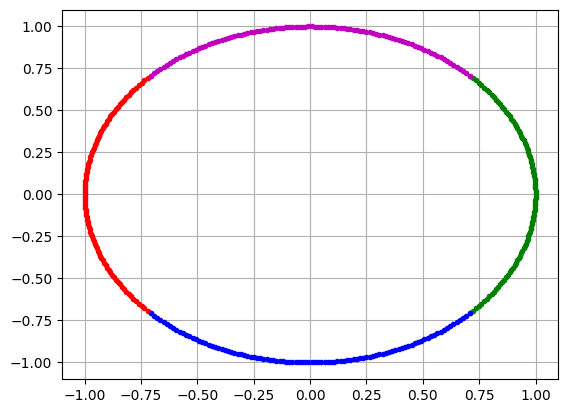

In [64]:

xs =linspace(0,1, 100) 
F1= lambda x1, x2 : (2.0*x1-1.0)*sqrt(1.0-0.5*(2.0*x2-1.0)**2)
F2= lambda x1, x2 : (2.0*x2-1.0)*sqrt(1.0-0.5*(2.0*x1-1.0)**2)
plt.plot(F1(0,xs), F2(0,xs),'r.')
plt.plot(F1(1,xs), F2(1,xs),'g.')
plt.plot(F1(xs, 0), F2(xs, 0),'b.')
plt.plot(F1(xs, 1), F2(xs, 1), 'm.')
plt.grid()
